# импорты

In [1]:
import tensorflow as tf
import pandas as pd
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline 
import json


# Задание 1

### загрузка

In [2]:
df = pd.read_csv('leaf/train.csv')
df.label = df.label.astype('str')
df

image_id label
0      1000015157.jpg     0
1      1000201771.jpg     3
2       100042118.jpg     1
3      1000723321.jpg     1
4      1000812911.jpg     3
...               ...   ...
21392   999068805.jpg     3
21393   999329392.jpg     3
21394   999474432.jpg     1
21395   999616605.jpg     4
21396   999998473.jpg     4

[21397 rows x 2 columns]

In [3]:
with open('leaf/label_num_to_disease_map.json') as f:
    raw_labels = f.read()

labels = json.loads(raw_labels)
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [4]:
train_df, val_df = train_test_split(df, test_size=0.25) # Разделение данных на обучающую и валидационную выборки
train_df = train_df.reset_index() # Сброс индексов
val_df = val_df.reset_index()

In [5]:
image_datagen = image.ImageDataGenerator(rescale=1./255)
# Создание генератора для обучающей выборки
train_gen = image_datagen.flow_from_dataframe(
    train_df, 
    "leaf/train_images", 
    x_col='image_id',
    y_col='label',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=16
)


Found 16047 validated image filenames belonging to 5 classes.


In [6]:
# Создание генератора для валидационной выборки
val_gen = image_datagen.flow_from_dataframe(
    val_df, 
    "leaf/train_images", 
    x_col='image_id',
    y_col='label',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=16
)

Found 5350 validated image filenames belonging to 5 classes.


### создание своей модели cnn

In [7]:
n_epoch = 5

In [8]:
def cnnNodel():
  model = keras.Sequential([
    keras.layers.Conv2D(32, (5,5),  activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, (5,5),  activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(128, (3,3),  activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(256, (3,3),  activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
  
    keras.layers.GlobalMaxPooling2D(),
    keras.layers.Dense(256, activation='relu'),

    keras.layers.Dense(5,  activation='softmax')
  ])
  return model

In [9]:
example = cnnNodel().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 128)      0

### SGD

In [10]:
sgdModel = cnnNodel()
sgdModel.compile(optimizer = tf.keras.optimizers.SGD(), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [11]:
sgdHistory = sgdModel.fit(train_gen, validation_data=val_gen, epochs=n_epoch, verbose=1,) #обучение

Epoch 1/5
1003/1003 [==============================] - 1396s 1s/step - loss: 1.1847 - accuracy: 0.6111 - val_loss: 1.1493 - val_accuracy: 0.6226
Epoch 2/5
1003/1003 [==============================] - 1385s 1s/step - loss: 1.1307 - accuracy: 0.6145 - val_loss: 1.0589 - val_accuracy: 0.6307
Epoch 3/5
1003/1003 [==============================] - 1295s 1s/step - loss: 1.0735 - accuracy: 0.6239 - val_loss: 1.0340 - val_accuracy: 0.6419
Epoch 4/5
1003/1003 [==============================] - 1451s 1s/step - loss: 1.0426 - accuracy: 0.6305 - val_loss: 0.9911 - val_accuracy: 0.6454
Epoch 5/5
1003/1003 [==============================] - 1287s 1s/step - loss: 1.0142 - accuracy: 0.6367 - val_loss: 1.0512 - val_accuracy: 0.6439


In [12]:
[sgdTest_loss, sgdTest_acc] = sgdModel.evaluate(val_gen) #оценка модели
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(sgdTest_loss, sgdTest_acc))

335/335 [==============================] - 112s 334ms/step - loss: 1.0512 - accuracy: 0.6439
Evaluation result on Test Data : Loss = 1.0512359142303467, accuracy = 0.6439252495765686


Text(0, 0.5, 'Accuracy')

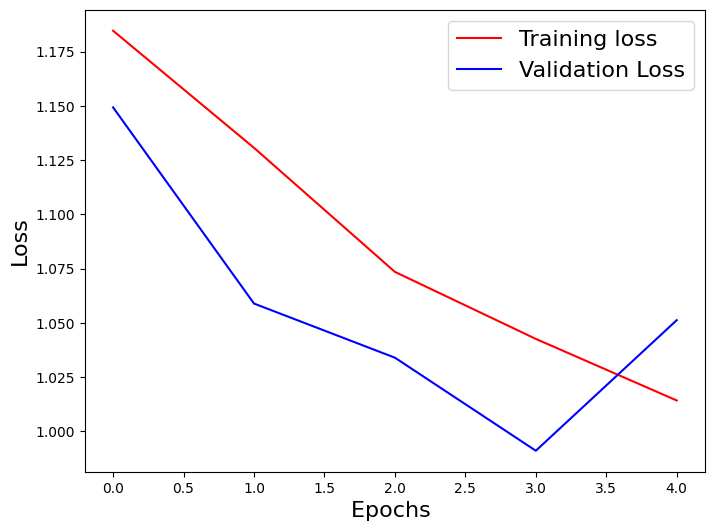

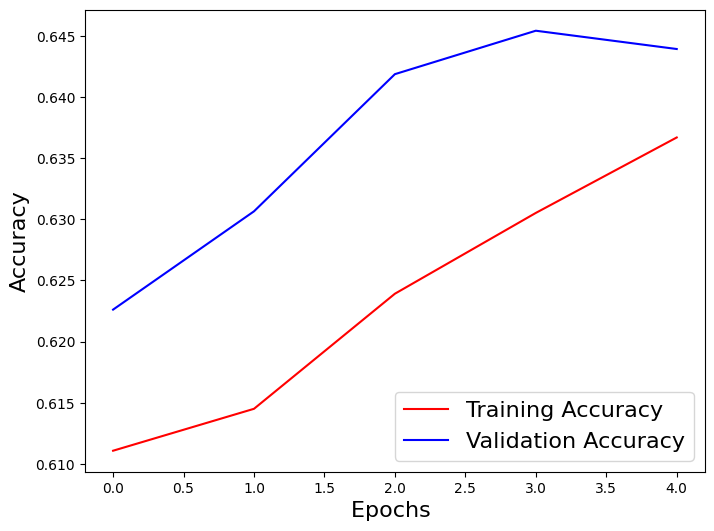

In [13]:
plt.figure(figsize=[8,6])
plt.plot(sgdHistory.history['loss'],'r')
plt.plot(sgdHistory.history['val_loss'],'b')
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(sgdHistory.history['accuracy'],'r') 
plt.plot(sgdHistory.history['val_accuracy'],'b') 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 

### RMS

In [14]:
rmsModel = cnnNodel()
rmsModel.compile(optimizer = tf.keras.optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [15]:
rmsHistory = rmsModel.fit(train_gen, validation_data=val_gen, epochs=n_epoch, verbose=1,) #обучение

Epoch 1/5
1003/1003 [==============================] - 1209s 1s/step - loss: 1.1444 - accuracy: 0.6167 - val_loss: 1.0730 - val_accuracy: 0.6327
Epoch 2/5
1003/1003 [==============================] - 1328s 1s/step - loss: 1.0465 - accuracy: 0.6290 - val_loss: 1.0048 - val_accuracy: 0.6464
Epoch 3/5
1003/1003 [==============================] - 1265s 1s/step - loss: 0.9579 - accuracy: 0.6483 - val_loss: 0.9198 - val_accuracy: 0.6600
Epoch 4/5
1003/1003 [==============================] - 1291s 1s/step - loss: 0.8975 - accuracy: 0.6665 - val_loss: 0.9255 - val_accuracy: 0.6839
Epoch 5/5
1003/1003 [==============================] - 1239s 1s/step - loss: 0.8590 - accuracy: 0.6778 - val_loss: 0.8393 - val_accuracy: 0.6890


In [16]:
[rmsTest_loss, rmsTest_acc] = rmsModel.evaluate(val_gen) #оценка модели
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(rmsTest_loss, rmsTest_acc))

335/335 [==============================] - 109s 325ms/step - loss: 0.8393 - accuracy: 0.6890
Evaluation result on Test Data : Loss = 0.8393452763557434, accuracy = 0.6889719367027283


Text(0, 0.5, 'Accuracy')

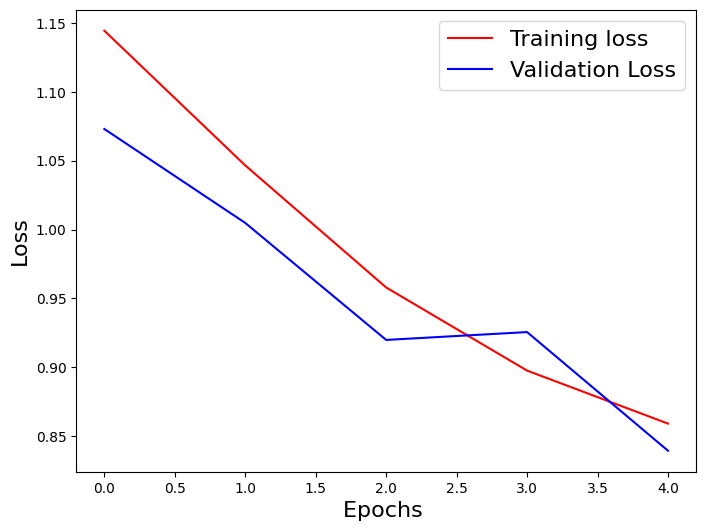

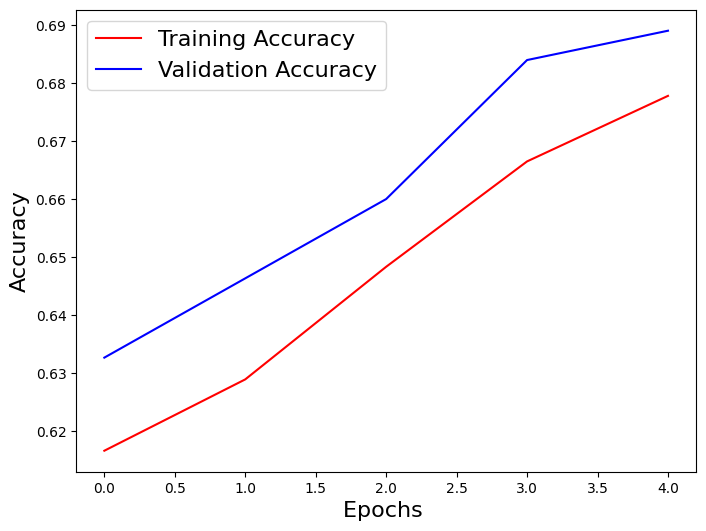

In [17]:
plt.figure(figsize=[8,6])
plt.plot(rmsHistory.history['loss'],'r')
plt.plot(rmsHistory.history['val_loss'],'b')
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(rmsHistory.history['accuracy'],'r') 
plt.plot(rmsHistory.history['val_accuracy'],'b') 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 

### Adam

In [18]:
adamModel = cnnNodel()
adamModel.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [19]:
adamHistory = adamModel.fit(train_gen, validation_data=val_gen, epochs=n_epoch, verbose=1,) #обучение

Epoch 1/5
1003/1003 [==============================] - 1252s 1s/step - loss: 1.1860 - accuracy: 0.6120 - val_loss: 1.1611 - val_accuracy: 0.6226
Epoch 2/5
1003/1003 [==============================] - 1248s 1s/step - loss: 1.1055 - accuracy: 0.6181 - val_loss: 1.0071 - val_accuracy: 0.6383
Epoch 3/5
1003/1003 [==============================] - 1191s 1s/step - loss: 0.9892 - accuracy: 0.6374 - val_loss: 0.9561 - val_accuracy: 0.6462
Epoch 4/5
1003/1003 [==============================] - 1197s 1s/step - loss: 0.9132 - accuracy: 0.6574 - val_loss: 0.8844 - val_accuracy: 0.6764
Epoch 5/5
1003/1003 [==============================] - 1103s 1s/step - loss: 0.8641 - accuracy: 0.6761 - val_loss: 0.8326 - val_accuracy: 0.6927


In [20]:
[adamTest_loss, adamTest_acc] = adamModel.evaluate(val_gen) #оценка модели
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(adamTest_loss, adamTest_acc))

335/335 [==============================] - 102s 304ms/step - loss: 0.8326 - accuracy: 0.6927
Evaluation result on Test Data : Loss = 0.8326038718223572, accuracy = 0.692710280418396


Text(0, 0.5, 'Accuracy')

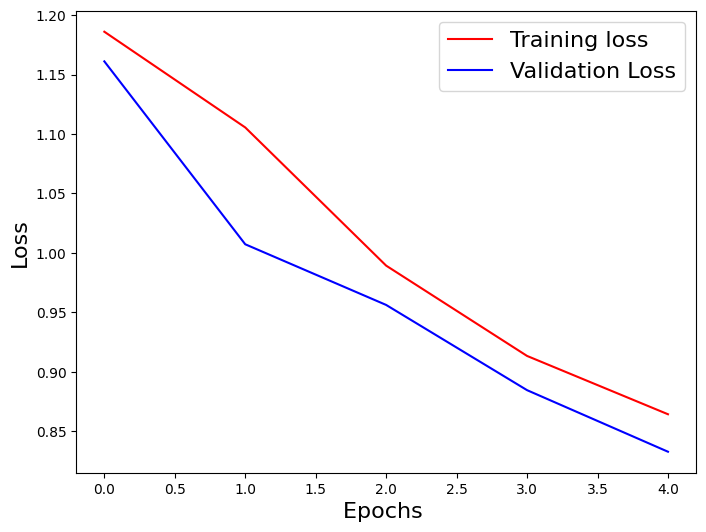

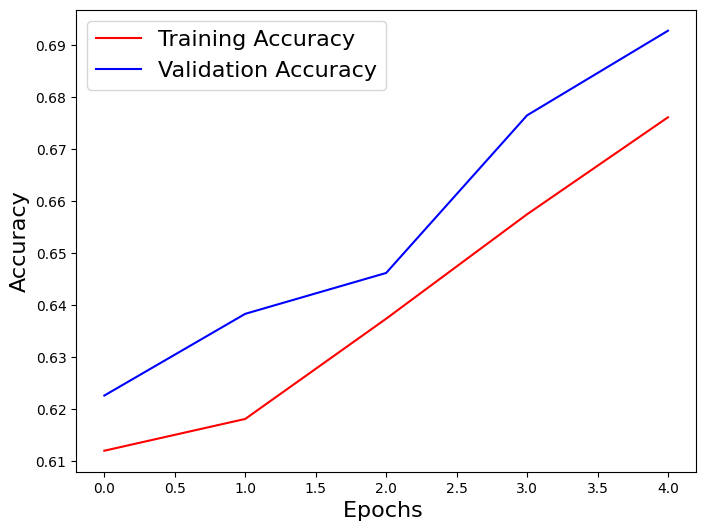

In [21]:
plt.figure(figsize=[8,6])
plt.plot(adamHistory.history['loss'],'r')
plt.plot(adamHistory.history['val_loss'],'b')
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(adamHistory.history['accuracy'],'r') 
plt.plot(adamHistory.history['val_accuracy'],'b') 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 

### обучение на ограниченном подмножестве данных


In [22]:
lil_train_gen = image_datagen.flow_from_dataframe(
    train_df[:2500],  # Используем только первые 2500 записей для обучения
    "leaf/train_images", 
    x_col='image_id',
    y_col='label',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=16
)


Found 2500 validated image filenames belonging to 5 classes.


In [23]:
lil_val_gen = image_datagen.flow_from_dataframe(
    val_df[:830], 
    "leaf/train_images", 
    x_col='image_id',
    y_col='label',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=16
)

Found 830 validated image filenames belonging to 5 classes.


In [24]:
lrScheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [25]:
lrFindModel = cnnNodel() # Создание модели для поиска оптимальной скорости обучения
lrFindModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [26]:
lrFindHistory = lrFindModel.fit(lil_train_gen, validation_data=lil_val_gen, epochs=70, verbose=1, callbacks=[lrScheduler])

Epoch 1/70
157/157 [==============================] - 177s 1s/step - loss: 1.5845 - accuracy: 0.6044 - val_loss: 1.5837 - val_accuracy: 0.6193 - lr: 1.0000e-08
Epoch 2/70
157/157 [==============================] - 185s 1s/step - loss: 1.5838 - accuracy: 0.6048 - val_loss: 1.5829 - val_accuracy: 0.6193 - lr: 1.1220e-08
Epoch 3/70
157/157 [==============================] - 207s 1s/step - loss: 1.5830 - accuracy: 0.6048 - val_loss: 1.5821 - val_accuracy: 0.6193 - lr: 1.2589e-08
Epoch 4/70
157/157 [==============================] - 214s 1s/step - loss: 1.5822 - accuracy: 0.6048 - val_loss: 1.5811 - val_accuracy: 0.6193 - lr: 1.4125e-08
Epoch 5/70
157/157 [==============================] - 218s 1s/step - loss: 1.5812 - accuracy: 0.6048 - val_loss: 1.5801 - val_accuracy: 0.6193 - lr: 1.5849e-08
Epoch 6/70
157/157 [==============================] - 220s 1s/step - loss: 1.5801 - accuracy: 0.6048 - val_loss: 1.5788 - val_accuracy: 0.6193 - lr: 1.7783e-08
Epoch 7/70
157/157 [====================

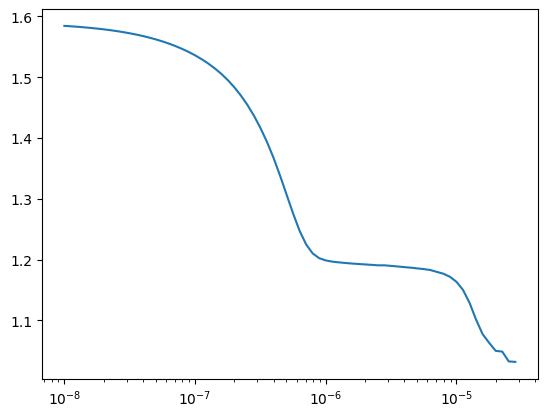

In [27]:
plt.semilogx(lrFindHistory.history["lr"], lrFindHistory.history["loss"]) # Визуализация зависимости потерь от скорости обучения

In [28]:
lrModel = cnnNodel() # Создание модели с оптимальной скоростью обучения
lrModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
lrHistory = lrModel.fit(train_gen, validation_data=val_gen, epochs=n_epoch, verbose=1,)

Epoch 1/5
1003/1003 [==============================] - 1229s 1s/step - loss: 1.3862 - accuracy: 0.6124 - val_loss: 1.2108 - val_accuracy: 0.6226
Epoch 2/5
1003/1003 [==============================] - 1245s 1s/step - loss: 1.1938 - accuracy: 0.6124 - val_loss: 1.1640 - val_accuracy: 0.6226
Epoch 3/5
1003/1003 [==============================] - 1231s 1s/step - loss: 1.1796 - accuracy: 0.6124 - val_loss: 1.1590 - val_accuracy: 0.6226
Epoch 4/5
1003/1003 [==============================] - 1223s 1s/step - loss: 1.1755 - accuracy: 0.6124 - val_loss: 1.1564 - val_accuracy: 0.6226
Epoch 5/5
1003/1003 [==============================] - 1222s 1s/step - loss: 1.1732 - accuracy: 0.6124 - val_loss: 1.1542 - val_accuracy: 0.6226


In [30]:
[lrTest_loss, lrTest_acc] = lrModel.evaluate(val_gen) # Оценка производительности модели на тестовых данных
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(lrTest_loss, lrTest_acc))

335/335 [==============================] - 108s 323ms/step - loss: 1.1542 - accuracy: 0.6226
Evaluation result on Test Data : Loss = 1.1542208194732666, accuracy = 0.6226168274879456


Text(0, 0.5, 'Accuracy')

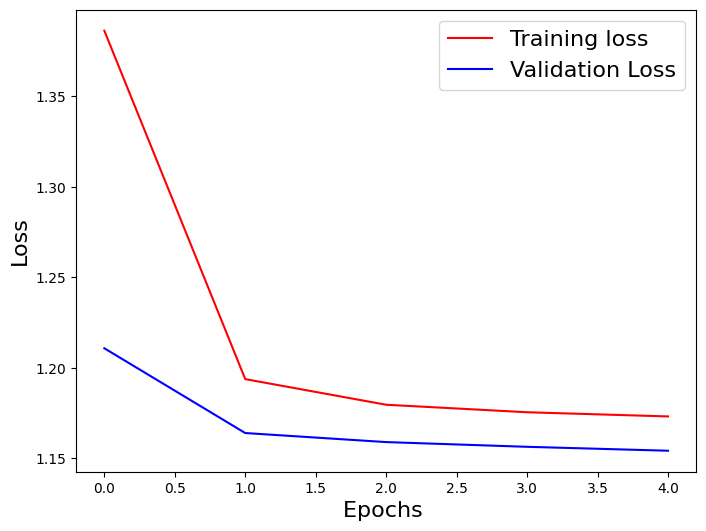

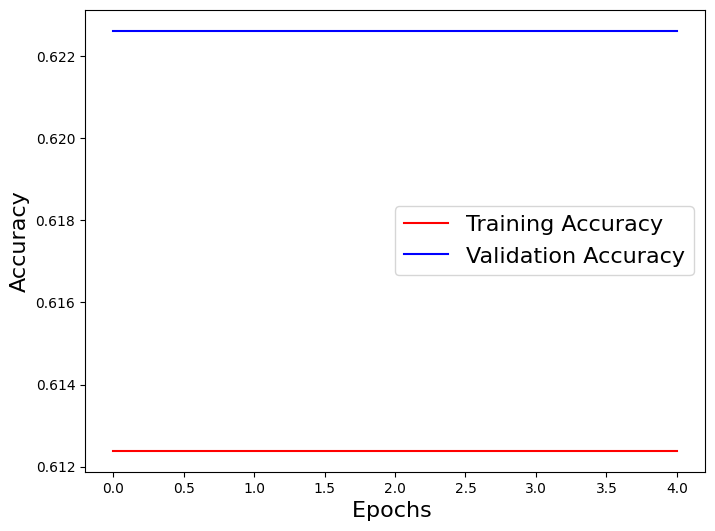

In [31]:
plt.figure(figsize=[8,6])
plt.plot(lrHistory.history['loss'],'r')
plt.plot(lrHistory.history['val_loss'],'b')
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(lrHistory.history['accuracy'],'r') 
plt.plot(lrHistory.history['val_accuracy'],'b') 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 

### аугментация

In [32]:
aug_datagen = image.ImageDataGenerator(  # Создание объекта аугментации данных
    rotation_range=10, # Углы вращения
    rescale=1./255, # Масштабирование значений
    shear_range=0.2,   # Диапазон сдвига 
    zoom_range=0.2, # Диапазон масштабирования
    horizontal_flip=True,  # Горизонтальное отражение
    fill_mode='nearest', # Режим заполнения пикселей
    width_shift_range=0.1, # Диапазон сдвига по горизонтали
    height_shift_range=0.1 # Диапазон сдвига по вертикали
)


In [33]:
# Создание генератора данных с аугментацией
aug_train_gen= aug_datagen.flow_from_dataframe(
    train_df, 
    "leaf/train_images", 
    x_col= 'image_id',
    y_col = 'label',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=16
)

Found 16047 validated image filenames belonging to 5 classes.


In [34]:
augModel = cnnNodel() # Создание модели для аугментированных данных
augModel.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [35]:
augHistory = augModel.fit(aug_train_gen, validation_data=val_gen, epochs=n_epoch, verbose=1,) # Обучение модели на аугментированных данных

Epoch 1/5
1003/1003 [==============================] - 1241s 1s/step - loss: 1.1395 - accuracy: 0.6182 - val_loss: 1.0593 - val_accuracy: 0.6350
Epoch 2/5
1003/1003 [==============================] - 1232s 1s/step - loss: 1.0421 - accuracy: 0.6283 - val_loss: 0.9702 - val_accuracy: 0.6525
Epoch 3/5
1003/1003 [==============================] - 1233s 1s/step - loss: 0.9573 - accuracy: 0.6459 - val_loss: 0.8767 - val_accuracy: 0.6650
Epoch 4/5
1003/1003 [==============================] - 1228s 1s/step - loss: 0.8914 - accuracy: 0.6667 - val_loss: 0.8345 - val_accuracy: 0.6905
Epoch 5/5
1003/1003 [==============================] - 1229s 1s/step - loss: 0.8473 - accuracy: 0.6836 - val_loss: 0.9225 - val_accuracy: 0.6650


Text(0, 0.5, 'Accuracy')

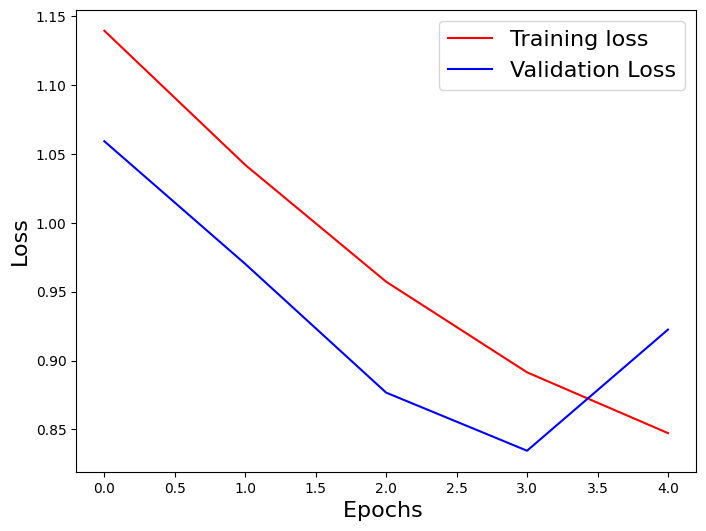

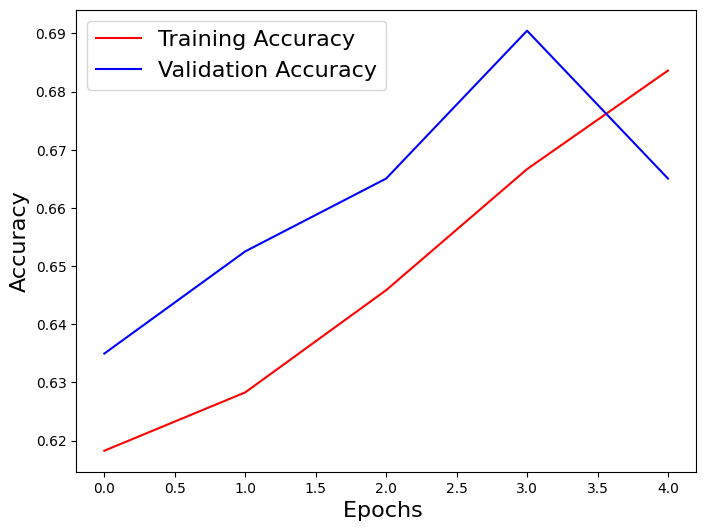

In [36]:
plt.figure(figsize=[8,6])
plt.plot(augHistory.history['loss'],'r')
plt.plot(augHistory.history['val_loss'],'b')
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(augHistory.history['accuracy'],'r') 
plt.plot(augHistory.history['val_accuracy'],'b') 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 

### VGG16

In [37]:
vgg = keras.applications.vgg16.VGG16(weights='imagenet', include_top=True) # Загрузка предобученной модели VGG16
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
class_layer = vgg.get_layer('block5_pool') # Извлечение слоя 'block5_pool' для классификации
class_out = class_layer.output

In [39]:
x = keras.layers.GlobalMaxPooling2D()(class_out)
x = keras.layers.Dense(5, activation='softmax')(x)

In [40]:
# Создание модели, объединяющей базовую модель VGG16 и новые слои
vggModel = Model(vgg.input, x)
vggModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vggModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:
for i, lay in enumerate(vggModel.layers[:-1]):
    lay.trainable = False

for i, lay in enumerate(vggModel.layers[-1:]):
    lay.trainable = True

vggModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
vggHistory = vggModel.fit(train_gen, validation_data=val_gen, epochs=n_epoch) #обучение

Epoch 1/5
1003/1003 [==============================] - 10842s 11s/step - loss: 1.2097 - accuracy: 0.6093 - val_loss: 1.1242 - val_accuracy: 0.6226
Epoch 2/5
1003/1003 [==============================] - 11288s 11s/step - loss: 1.1654 - accuracy: 0.6110 - val_loss: 1.0968 - val_accuracy: 0.6226
Epoch 3/5
1003/1003 [==============================] - 12568s 13s/step - loss: 1.0841 - accuracy: 0.6154 - val_loss: 1.0093 - val_accuracy: 0.6419
Epoch 4/5
1003/1003 [==============================] - 12511s 12s/step - loss: 0.9912 - accuracy: 0.6335 - val_loss: 0.9533 - val_accuracy: 0.6493
Epoch 5/5
1003/1003 [==============================] - 10748s 11s/step - loss: 0.9280 - accuracy: 0.6500 - val_loss: 0.9282 - val_accuracy: 0.6613


### ИТОГ

In [43]:
# Создание и заполнение таблицы результатов
results = pd.DataFrame([['Custom model + SGD Momentum', 0.6841, 0.6637]], columns=['Эксперимент', 'train accuracy', 'test accuracy'])

new_row = {'Эксперимент':'Custom model + RMSProp', 'train accuracy': 0.7063, 'test accuracy': 0.6308}
results = results.append(new_row,ignore_index=True)

new_row = {'Эксперимент':'Custom model + Adam', 'train accuracy': 0.7370, 'test accuracy': 0.7045}
results = results.append(new_row,ignore_index=True)

new_row = {'Эксперимент':'Custom model + Adam + Learning rate', 'train accuracy': 0.6144, 'test accuracy': 0.6164}
results = results.append(new_row,ignore_index=True)

new_row = {'Эксперимент':'Custom model + Adam + Augmentation', 'train accuracy': 0.7141, 'test accuracy': 0.7292}
results = results.append(new_row,ignore_index=True)

new_row = {'Эксперимент':'VGG16 + Adam', 'train accuracy': 0.6171, 'test accuracy': 0.6086}
results = results.append(new_row,ignore_index=True)

results

C:\Users\puhov\AppData\Local\Temp\ipykernel_14220\4051062731.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(new_row,ignore_index=True)
C:\Users\puhov\AppData\Local\Temp\ipykernel_14220\4051062731.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(new_row,ignore_index=True)
C:\Users\puhov\AppData\Local\Temp\ipykernel_14220\4051062731.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(new_row,ignore_index=True)
C:\Users\puhov\AppData\Local\Temp\ipykernel_14220\4051062731.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(new_row,i

Эксперимент  train accuracy  test accuracy
0          Custom model + SGD Momentum          0.6841         0.6637
1               Custom model + RMSProp          0.7063         0.6308
2                  Custom model + Adam          0.7370         0.7045
3  Custom model + Adam + Learning rate          0.6144         0.6164
4   Custom model + Adam + Augmentation          0.7141         0.7292
5                         VGG16 + Adam          0.6171         0.6086

# Задание 2

### загрузка

In [44]:
X = []
for filename in sorted(os.listdir('dataset/semantic_drone_dataset/original_images/')):
    a = cv2.imread('dataset/semantic_drone_dataset/original_images/' + filename)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = cv2.resize(a, (128, 128))
    a = a / 255 # Нормализация
    X.append(a)
    
X = np.array(X)

In [45]:
Y = []
for filename in sorted(os.listdir('dataset/semantic_drone_dataset/label_images_semantic/')):
    a = cv2.imread('dataset/semantic_drone_dataset/label_images_semantic/' + filename, cv2.IMREAD_GRAYSCALE)
    a = cv2.resize(a, (128, 128))
    Y.append(a)
    
Y = np.array(Y)
Yc = to_categorical(Y)

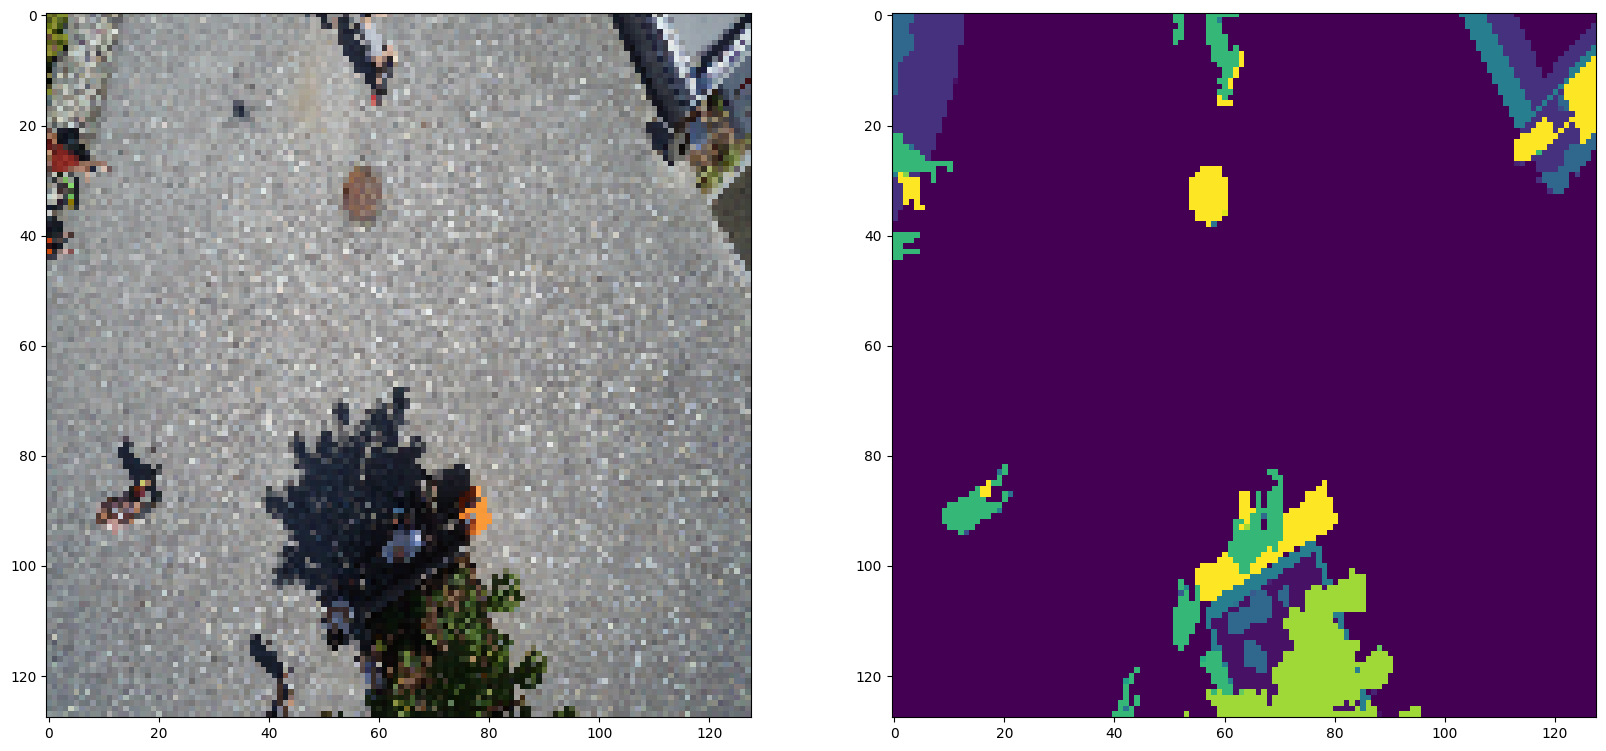

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[0])
axs[1].imshow(Y[0])

### модель 1

In [47]:
test_images = X[395:]
test_labels = Yc[395:]

x_train, x_val, y_train, y_val = train_test_split(X[0:-5], Yc[0:-5], test_size = 0.15)

In [48]:
def unet(num_classes = 23, image_shape = (128, 128, 3)):
    inputs = Input(image_shape)
    
     # Encoder
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
     # Decoder
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    # Выходной слой с softmax-активацией для предсказания классов
    conv10 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = Model(inputs, conv10)
    
    return model

In [49]:
model1 = unet()

model1.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

history1 = model1.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=16, epochs=40)

Epoch 1/40
21/21 [==============================] - 210s 10s/step - loss: 233.8103 - accuracy: 0.2432 - val_loss: 2.1844 - val_accuracy: 0.4487
Epoch 2/40
21/21 [==============================] - 210s 10s/step - loss: 2.0876 - accuracy: 0.4261 - val_loss: 1.9108 - val_accuracy: 0.4976
Epoch 3/40
21/21 [==============================] - 209s 10s/step - loss: 1.8608 - accuracy: 0.4974 - val_loss: 1.8139 - val_accuracy: 0.5213
Epoch 4/40
21/21 [==============================] - 209s 10s/step - loss: 1.7918 - accuracy: 0.5087 - val_loss: 1.7321 - val_accuracy: 0.5310
Epoch 5/40
21/21 [==============================] - 208s 10s/step - loss: 1.7582 - accuracy: 0.5162 - val_loss: 1.6989 - val_accuracy: 0.5275
Epoch 6/40
21/21 [==============================] - 218s 10s/step - loss: 1.6731 - accuracy: 0.5268 - val_loss: 1.6470 - val_accuracy: 0.5432
Epoch 7/40
21/21 [==============================] - 230s 11s/step - loss: 1.5834 - accuracy: 0.5474 - val_loss: 1.5079 - val_accuracy: 0.5623
Epoc

Text(0, 0.5, 'Accuracy')

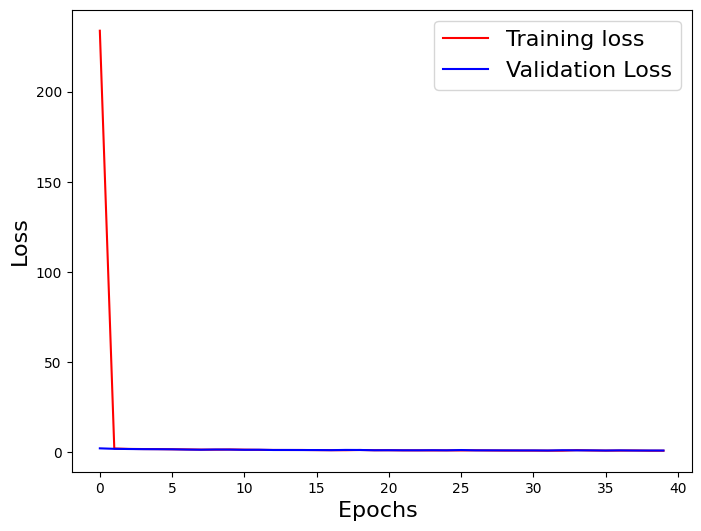

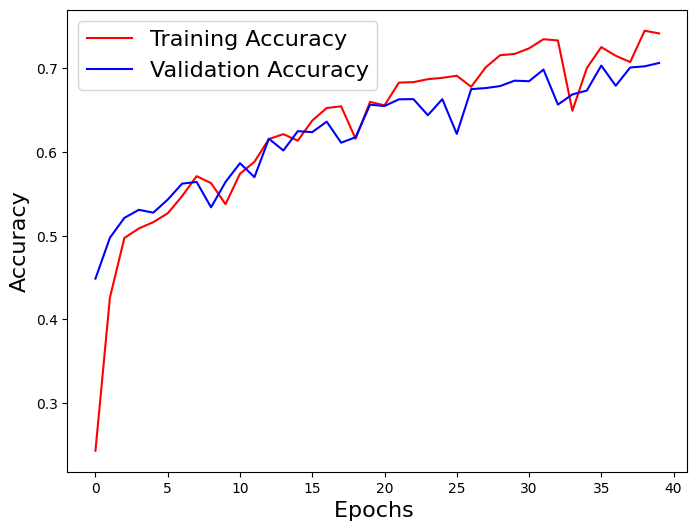

In [50]:
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],'r')
plt.plot(history1.history['val_loss'],'b')
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],'r') 
plt.plot(history1.history['val_accuracy'],'b') 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 

In [51]:
preds = []
for image in test_images:
  pred = model1.predict(np.expand_dims(image, 0))
  pred_mask = np.argmax(pred, axis=-1)
  preds.append(pred_mask[0])

In [52]:
def plot_pred(img, true, predict):
  fig, axs = plt.subplots(1, 3, figsize=(20, 10))
  axs[0].imshow(img)
  axs[0].set_title('Image')
  axs[1].imshow(np.argmax(true, axis=-1))
  axs[1].set_title('Ground Truth')
  axs[2].imshow(predict)
  axs[2].set_title('Prediction')

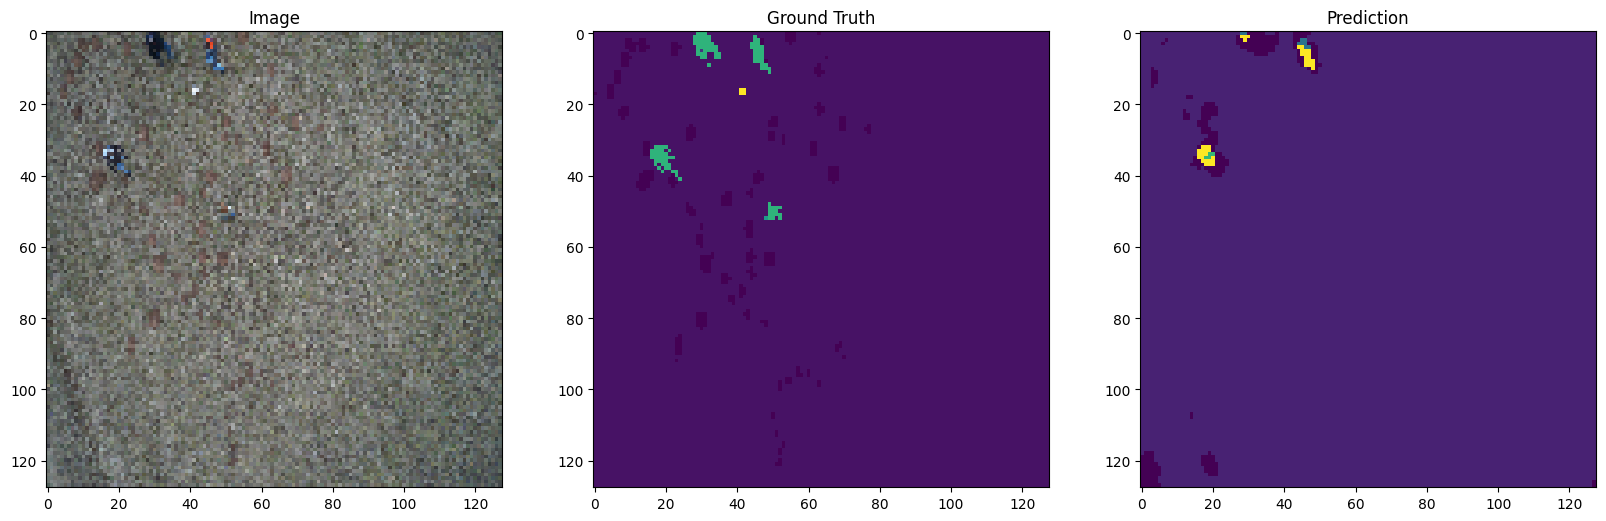

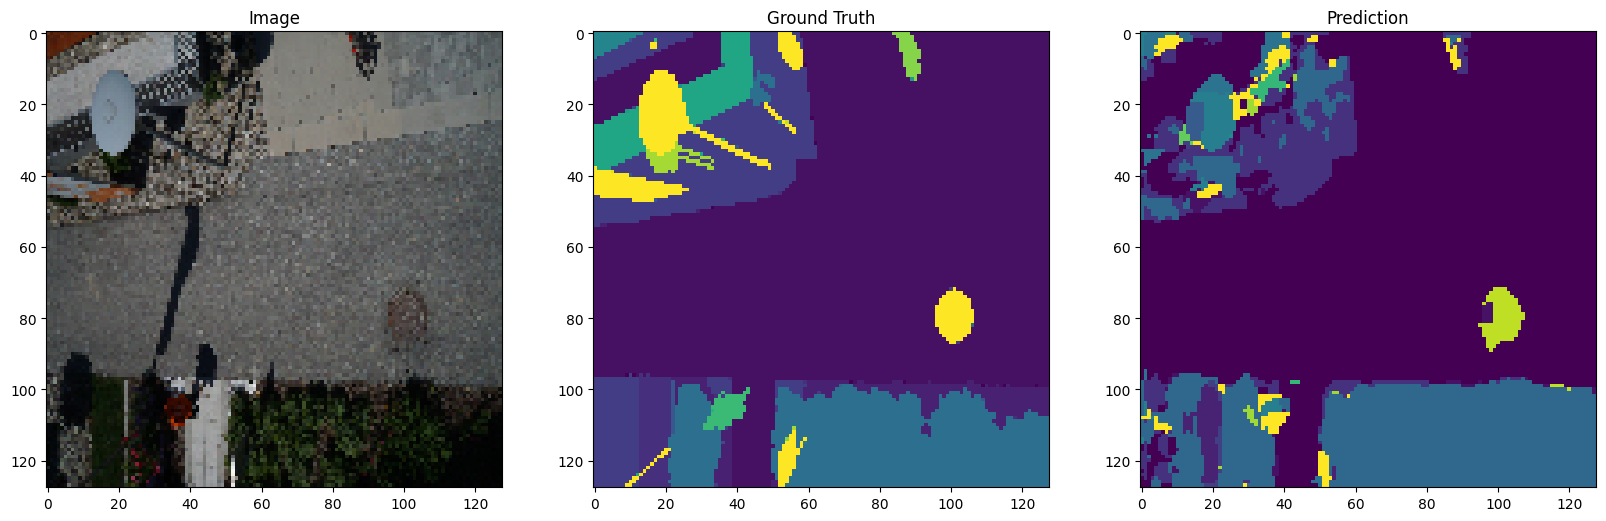

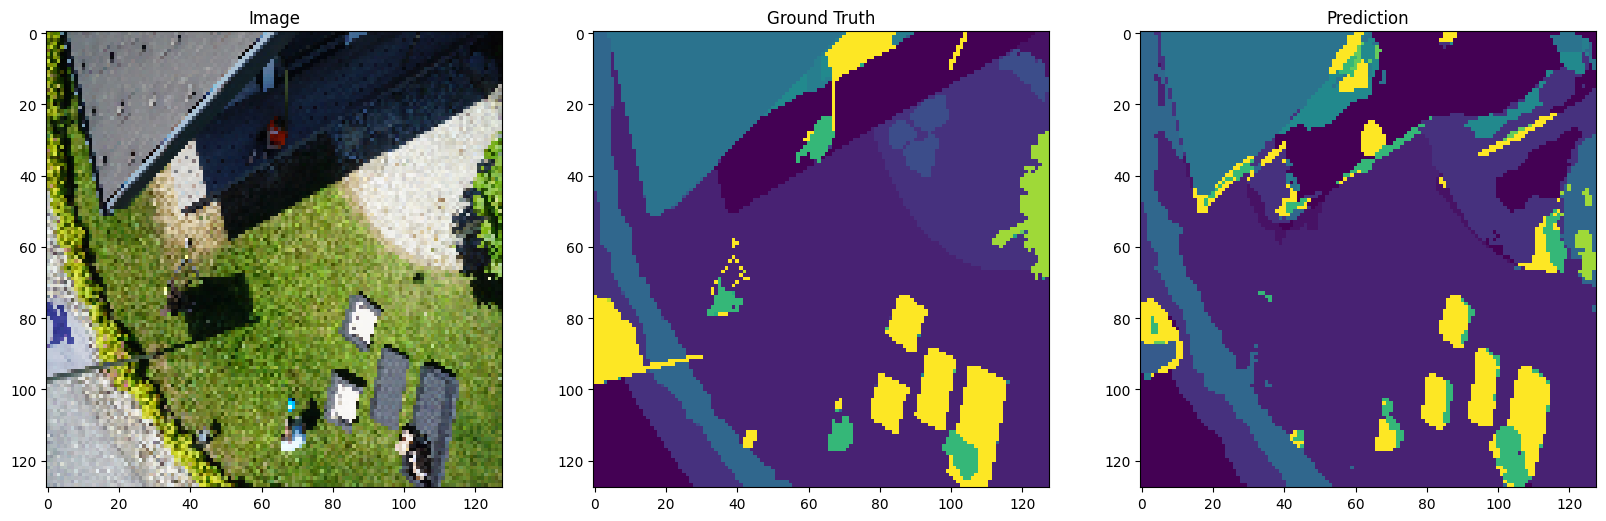

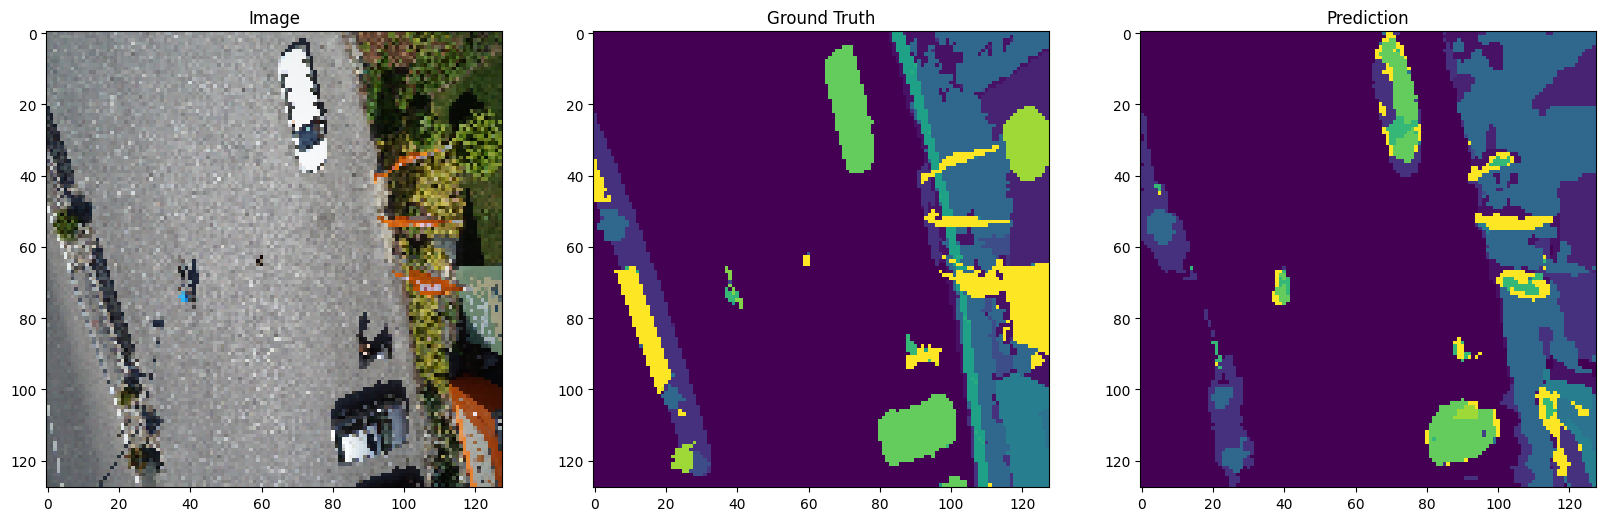

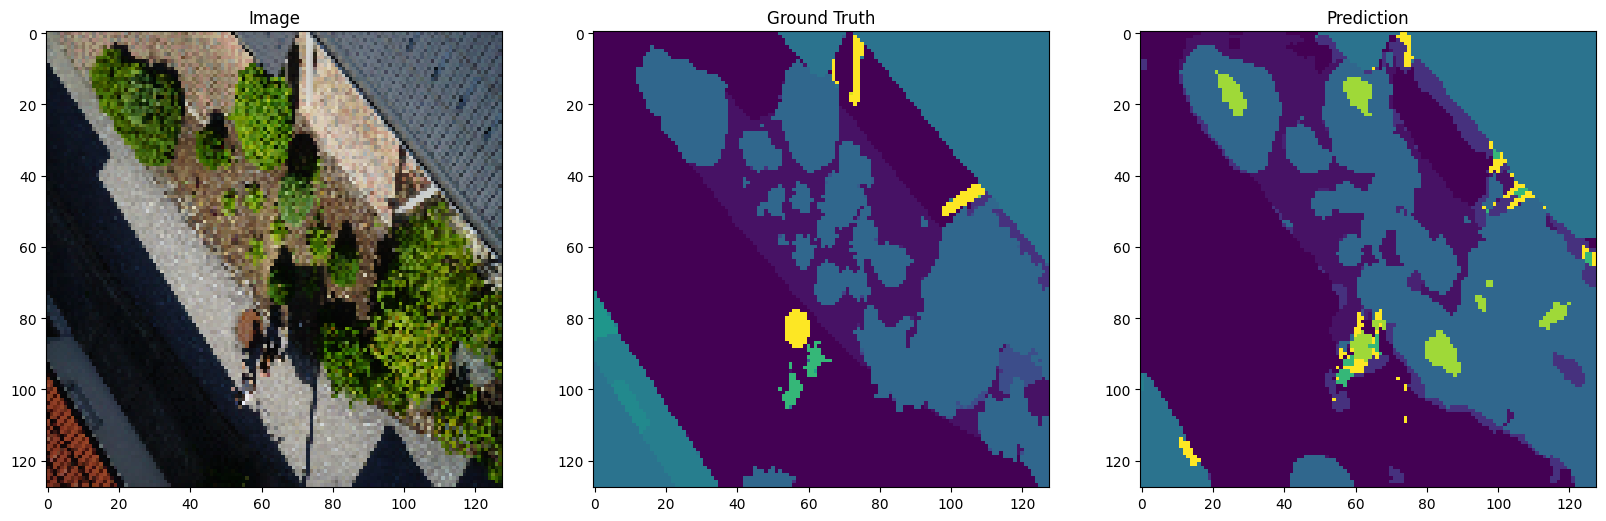

In [53]:
for i in range(len(test_images)):
  plot_pred(test_images[i], test_labels[i], preds[i])

### модель 2

In [54]:
def unet2(num_classes = 23, image_shape = (128, 128, 3)):
    inputs = Input(image_shape)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    #decoder
    up6 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(pool3))
    merge6 = concatenate([up6, conv3], axis = 3)
    conv6 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    # Выходной слой с softmax-активацией для предсказания
    conv10 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = Model(inputs, conv10)
    
    return model

In [55]:
model2 = unet2()

model2.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

history2 = model2.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=16, epochs=40)

Epoch 1/40
21/21 [==============================] - 137s 6s/step - loss: 2.7006 - accuracy: 0.3831 - val_loss: 2.0048 - val_accuracy: 0.4773
Epoch 2/40
21/21 [==============================] - 136s 7s/step - loss: 1.9207 - accuracy: 0.4804 - val_loss: 1.7942 - val_accuracy: 0.5064
Epoch 3/40
21/21 [==============================] - 146s 7s/step - loss: 1.7382 - accuracy: 0.5078 - val_loss: 1.6808 - val_accuracy: 0.5214
Epoch 4/40
21/21 [==============================] - 155s 7s/step - loss: 1.6066 - accuracy: 0.5343 - val_loss: 1.5614 - val_accuracy: 0.5476
Epoch 5/40
21/21 [==============================] - 159s 8s/step - loss: 1.5082 - accuracy: 0.5561 - val_loss: 1.4630 - val_accuracy: 0.5661
Epoch 6/40
21/21 [==============================] - 162s 8s/step - loss: 1.4366 - accuracy: 0.5741 - val_loss: 1.3711 - val_accuracy: 0.5906
Epoch 7/40
21/21 [==============================] - 165s 8s/step - loss: 1.4075 - accuracy: 0.5747 - val_loss: 1.5066 - val_accuracy: 0.5433
Epoch 8/40
21

Text(0, 0.5, 'Accuracy')

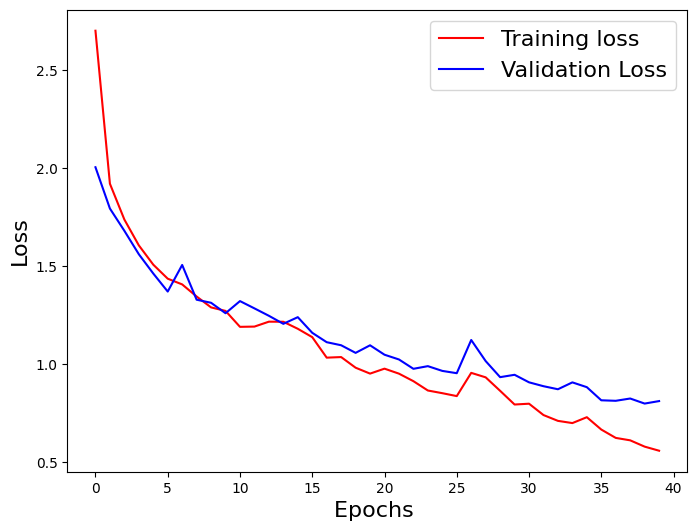

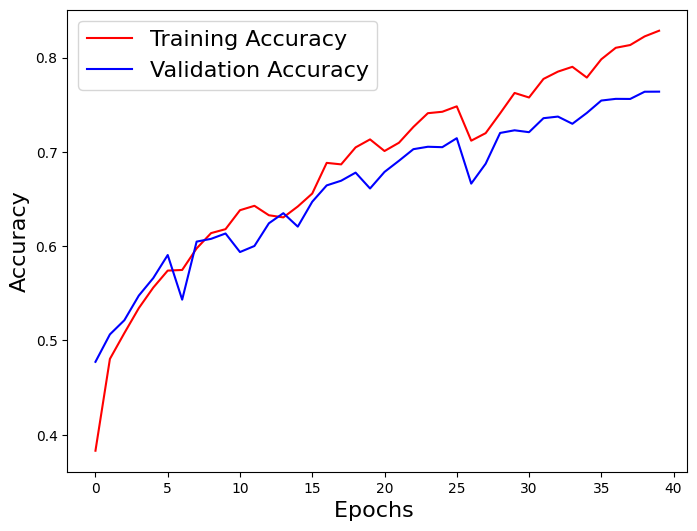

In [56]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r')
plt.plot(history2.history['val_loss'],'b')
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(history2.history['accuracy'],'r') 
plt.plot(history2.history['val_accuracy'],'b') 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 

In [57]:
preds2 = []
for image in test_images:
  pred = model2.predict(np.expand_dims(image, 0))
  pred_mask = np.argmax(pred, axis=-1)
  preds2.append(pred_mask[0])

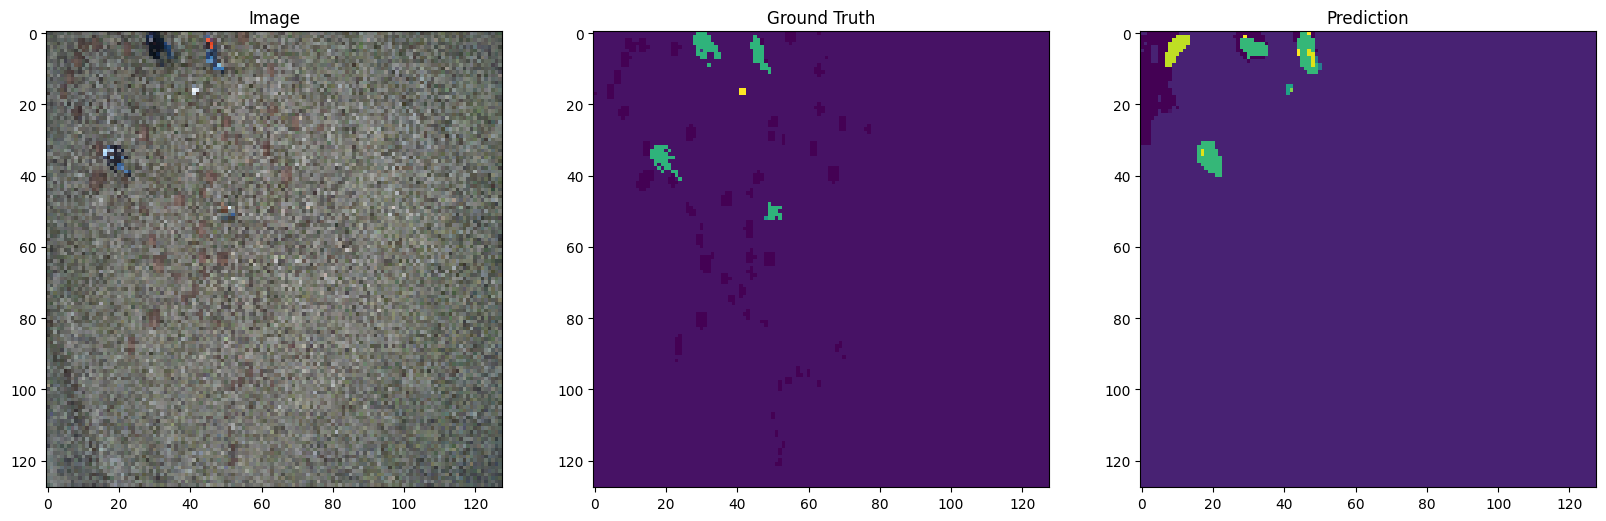

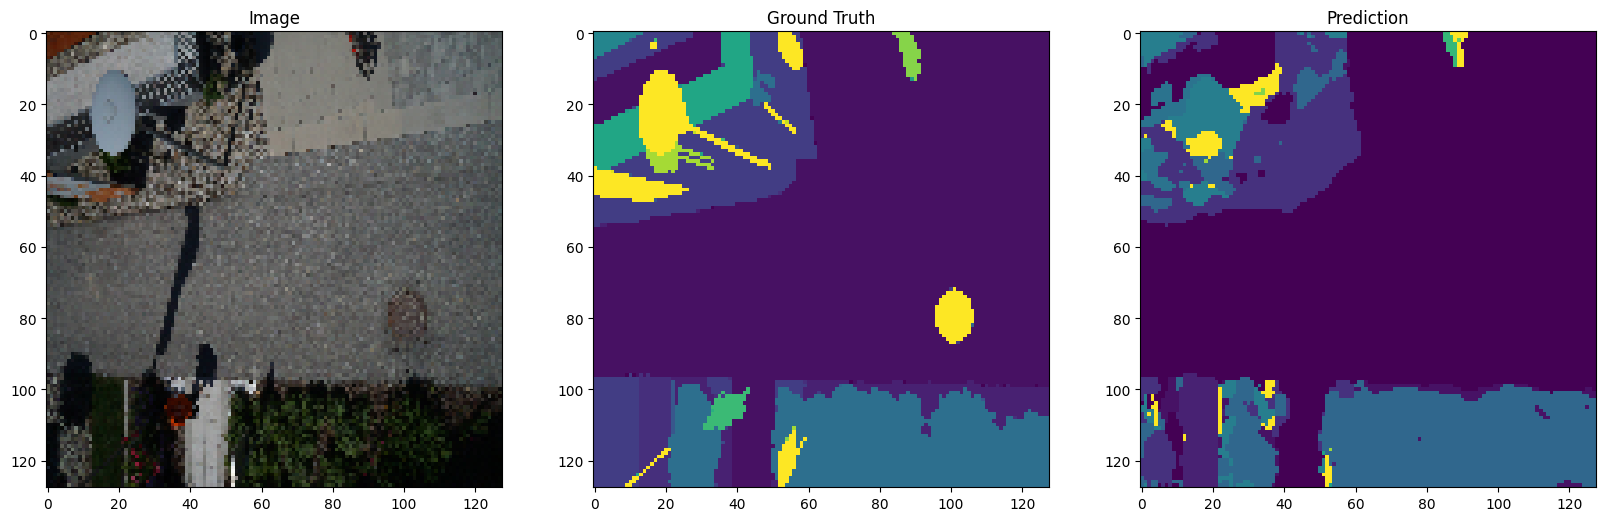

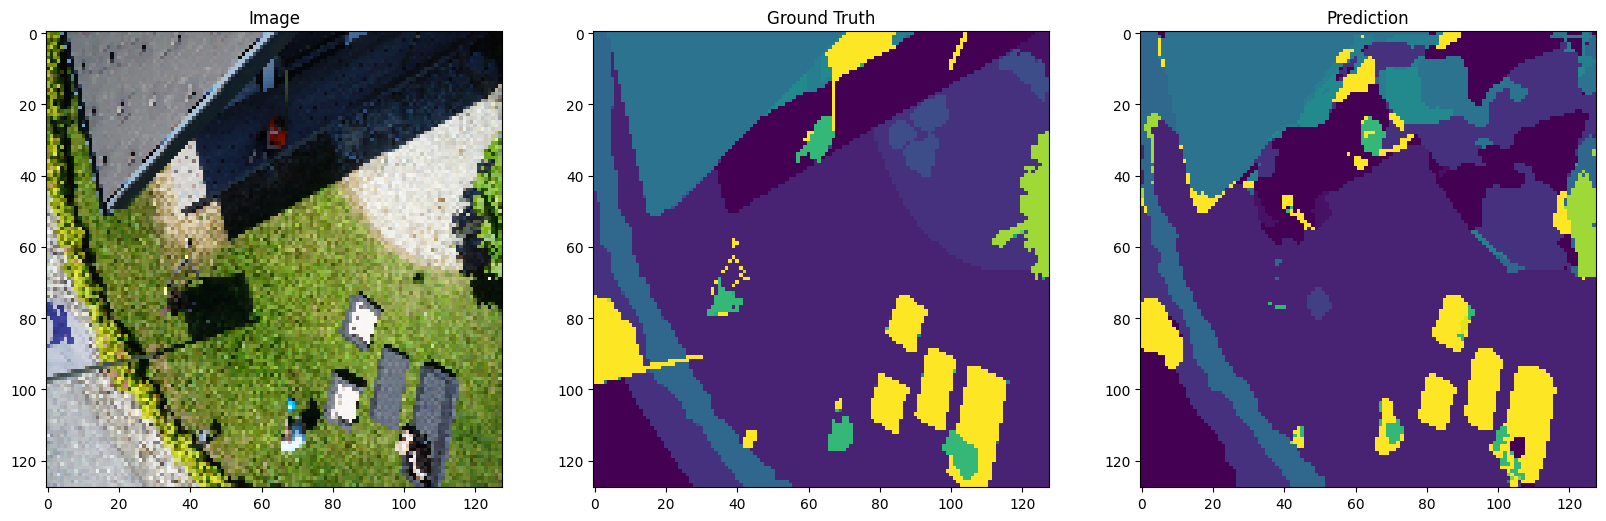

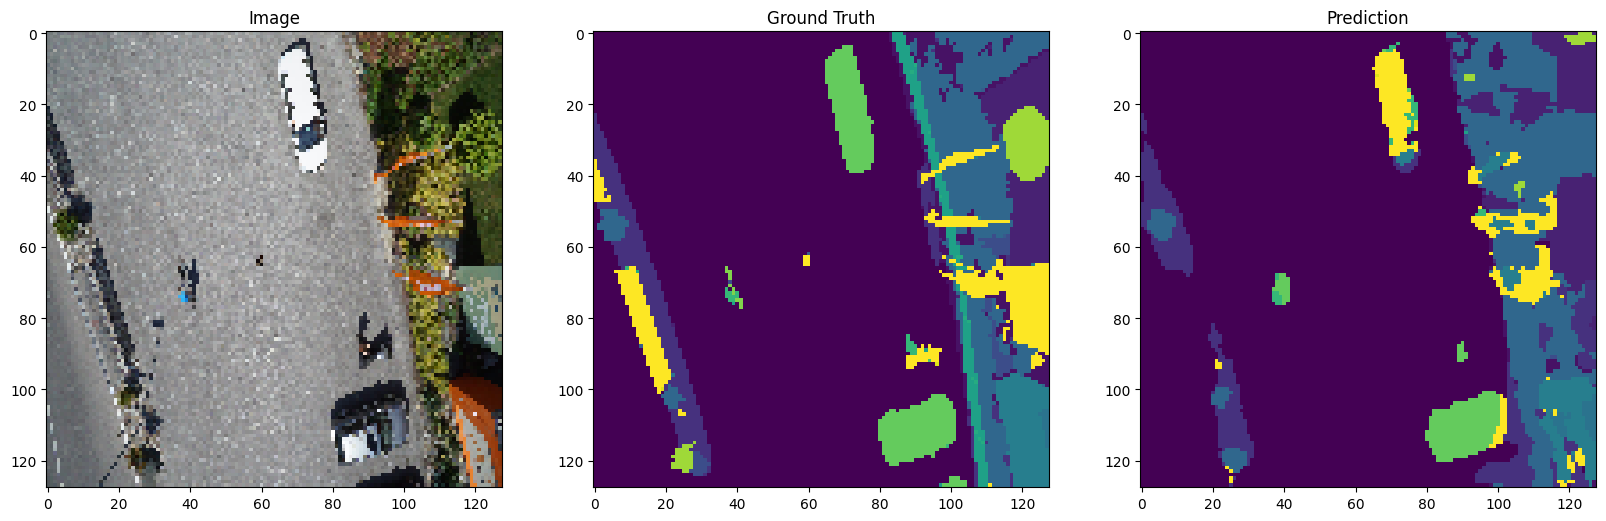

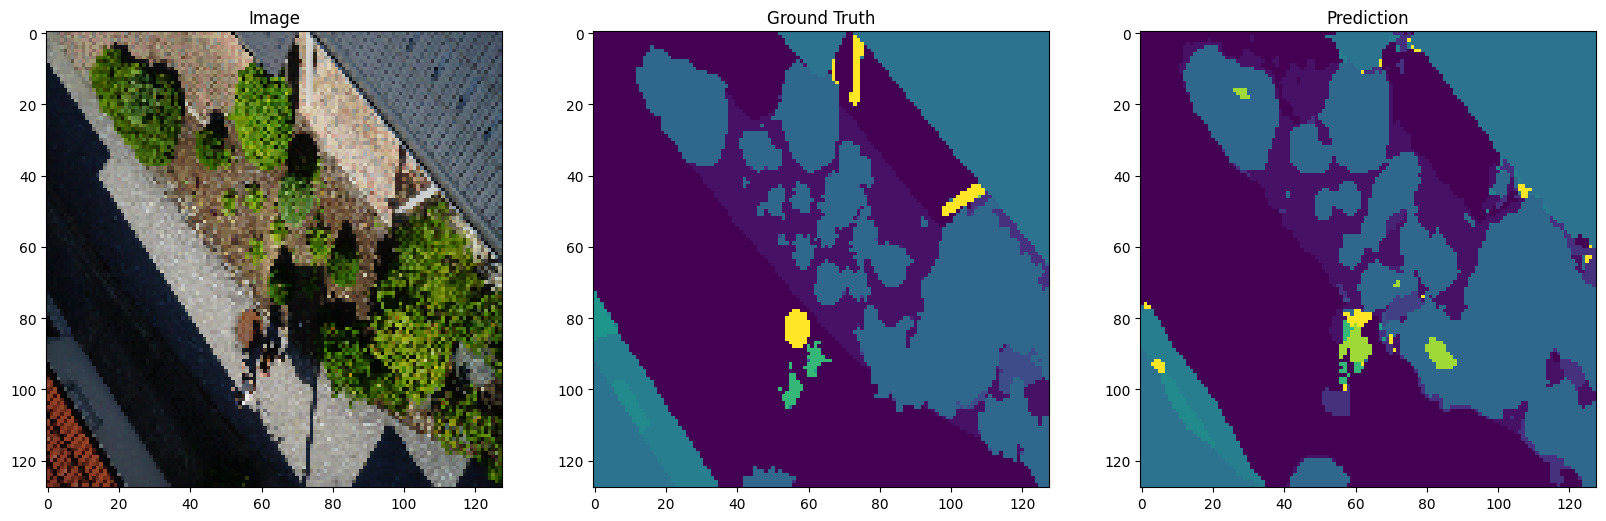

In [58]:
for i in range(len(test_images)):
  plot_pred(test_images[i], test_labels[i], preds2[i])